In [1]:
import numpy as np
import sys
import h5py
import matplotlib.pyplot as plt
from colossus.cosmology import cosmology
from tetrahedrafunc import *
from scipy.spatial import cKDTree

In [2]:
mytetsize=16 # take a large-sized set of tetrahedra

# reading snapshot
fileidx=62
f=h5py.File('snapshot_%03d.hdf5'%fileidx,'r')
Loc=np.array(f['PartType1']['Coordinates'])
ParticleIDs=np.array(f['PartType1']['ParticleIDs'])
currentz=dict(f['Header'].attrs)['Redshift']
Ndim=int(np.cbrt(dict(f['Header'].attrs)['NumPart_Total'][1]))
celllen=dict(f['Header'].attrs)['BoxSize']/Ndim # length of cell
rhoavg=1/(celllen**3)

#sort the particles according to ID
Loc_sorted=np.copy(Loc)
indexes=np.argsort(ParticleIDs)
Loc_sorted=Loc_sorted[indexes]

#take care of the periodic boundary
x = celllen*(0.5+np.arange(Ndim))
xg = np.meshgrid(x,x,x, indexing='ij')
xl = np.ravel(xg[0])
yl = np.ravel(xg[1])
zl = np.ravel(xg[2])
gridPoints=np.vstack([xl,yl,zl]).transpose()
delta=Loc_sorted - gridPoints
Loc_shifted=np.copy(Loc_sorted)
for dim in range(3):
    too_small = delta[:,dim] < -celllen*Ndim/2
    too_big = delta[:,dim] > celllen*Ndim/2
    Loc_shifted[too_big,dim] -= celllen*Ndim
    Loc_shifted[too_small,dim] += celllen*Ndim

#reshape into a 3d mesh
grid3d=np.stack(xg,axis=3)
Loc3d=Loc_shifted.reshape(Ndim,Ndim,Ndim,3) 

# get volumes of tetrahedra
vol = get_tet_volumes_anysize(Ndim-mytetsize,Loc3d,mytetsize)
volflat=vol.reshape(((Ndim-mytetsize)**3,6))
dens_vol = (mytetsize**3)/np.abs( volflat.ravel() )/6

# make meshes spaced by tetrahedra size
xx=np.arange(Ndim)[0:Ndim:mytetsize]
xg=np.meshgrid(xx,xx,xx,indexing='ij')
Ndimtet=len(xx)

#establish connectivity list 
conn_all_3idx = get_tet_conn(Ndimtet-1)
conn_all = conn_all_3idx[:,:,0]*Ndimtet**2 + conn_all_3idx[:,:,1] * Ndimtet + conn_all_3idx[:,:,2]


In [3]:
# we have mytetsize^3 sets of tetrahedra meshes
# labeled by lower left corner (xshift,yshift,zshift)
# For each set of tetrahedra mesh (which would be a tesselation of the box), 
# we take a denser grid of points, paint the tetrahedra density 
# this dense grid of points will be use to interpolate our density field
# the field is interpolated in a simple way:
# When we query density on a new coordinate, we look for the nearest point
xshift=0
yshift=0
zshift=0

# select meshes spaced by mytetsize
# with lower left corner being (xshift,yshift,zshift)
xx=np.arange(Ndim)[0:Ndim:mytetsize]
xg=np.meshgrid(xx,xx,xx,indexing='ij')
xidxs=np.ravel(xg[0])+xshift
yidxs=np.ravel(xg[1])+yshift
zidxs=np.ravel(xg[2])+zshift
selected3idx=np.array([xidxs,yidxs,zidxs]).transpose()
selected = selected3idx[:,0]*Ndim**2+selected3idx[:,1]*Ndim+selected3idx[:,2]
# the "selected" points establish the tessellation
Loc_select=Loc_shifted[selected]

# dense grid is where we paint the density fields
denseN=100
x = celllen*Ndim/denseN*(0.5+np.arange(denseN))
xg = np.meshgrid(x,x,x, indexing='ij')
xl = np.ravel(xg[0])
yl = np.ravel(xg[1])
zl = np.ravel(xg[2])
denseGrid=np.vstack([xl,yl,zl]).transpose()

# loop over tetrahedra, paint points in each tetrahedron with tetrahedron density
deltafield = np.zeros(denseN**3)-1
# testvol0=[]
# testvol1=[]
cnt=0
for i in range(len(conn_all)):
    current_tet=conn_all[i]
    if cnt%100==0:
        print(cnt)
    cnt=cnt+1
    # find the four vertices of the tetrahedra
    vets = Loc_select[current_tet,:]
    # preselection. Find those in the bounding box of the tetrahedron
    min_x,min_y,min_z = np.min(vets,axis=0)
    max_x,max_y,max_z = np.max(vets,axis=0)
    mask_x = (denseGrid[:, 0] >= min_x) & (denseGrid[:, 0] <= max_x)
    mask_y = (denseGrid[:, 1] >= min_y) & (denseGrid[:, 1] <= max_y)
    mask_z = (denseGrid[:, 2] >= min_z) & (denseGrid[:, 2] <= max_z)
    mask = mask_x & mask_y & mask_z
    inbox_indices = np.where(mask)[0]
    # then for those points inbox, find whether they are in the tetrahedron
    insidepts=InTetraList(denseGrid[inbox_indices],vets[0],vets[1],vets[2],vets[3])
    #print(len(insidepts))
    # as a sheck, record the volume of this tetrahedron 
    # and also compute the vol here using the vertices
    # take care of the idxs
    tet6id = i%6
    tetxid = int(int(i/6) / (Ndimtet-1)**2)
    tetyid = int(( int(i/6) - tetxid*(Ndimtet-1)**2 ) / (Ndimtet-1))
    tetzid = int(i/6) % (Ndimtet-1)
    currentvol = vol[tetxid*mytetsize+xshift,tetyid*mytetsize+yshift,tetzid*mytetsize+zshift,tet6id]
    #testvol0.append(currentvol)
    # compute volume using vertices
    #testvol1.append( np.sum( np.cross(vets[1]-vets[3], vets[2]-vets[3])* (vets[0]-vets[3]))/6 )
    # paint the density
    currentrho = (mytetsize**3)/6 / np.abs(currentvol)
    deltafield[inbox_indices[insidepts]] += currentrho/rhoavg
    

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


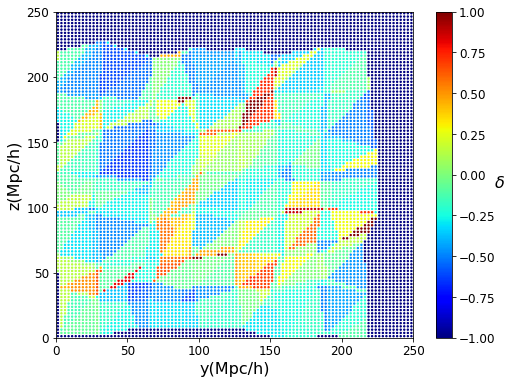

In [4]:
# plot a layer of the sample points
from matplotlib  import cm

selected_xlayer = 50
plt.figure().set_size_inches([8,6])

plt.scatter(denseGrid[selected_xlayer*denseN**2:(selected_xlayer+1)*denseN**2,1],
            denseGrid[selected_xlayer*denseN**2:(selected_xlayer+1)*denseN**2,2],
            c = deltafield[selected_xlayer*denseN**2:(selected_xlayer+1)*denseN**2] ,
            s=2, cmap = cm.jet, vmin=-1,vmax=1 )
plt.xlim(0,250)
plt.ylim(0,250)
cbar=plt.colorbar()
cbar.ax.set_ylabel('$\\delta$',fontsize=16,rotation=0)
cbar.ax.tick_params(labelsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('y(Mpc/h)',fontsize=16)
plt.ylabel('z(Mpc/h)',fontsize=16)
#plt.savefig('deltafield_snap%03d_tetsize%d_xlayer%d.pdf'%(fileidx,mytetsize,selected_xlayer),bbox_inches='tight')
plt.show()

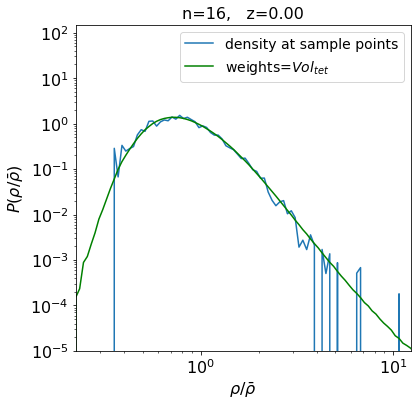

In [5]:
# compare with volume-weighted PDF
plt.figure().set_size_inches([6,6])

dm,rhobins=np.histogram(deltafield[np.where(deltafield!=-1)[0]]+1,bins=np.power(10.0,np.arange( -2,5, 0.02 )),density=True)
rhoxaxis=(rhobins[0:dm.shape[0]]+rhobins[1:dm.shape[0]+1])/2
plt.loglog(rhoxaxis,dm,label='density at sample points')

dm,rhobins=np.histogram(dens_vol/rhoavg,bins=np.power(10.0,np.arange( -2,5, 0.02 )),density=True,weights=1/dens_vol)
rhoxaxis=(rhobins[0:dm.shape[0]]+rhobins[1:dm.shape[0]+1])/2
plt.loglog(rhoxaxis,dm,'g',label='weights=$Vol_{tet}$') # /len(primDen) to normalize
xr=rhoxaxis[np.where(dm>1e-5)[0][-1]]
xl=rhoxaxis[np.where(dm>1e-5)[0][0]]

plt.xlim(xl,xr)
plt.ylim(1e-5,150)
plt.legend(fontsize=14)

plt.xlabel('$\\rho/\\bar{\\rho}$',fontsize=16)
plt.ylabel('$ P(\\rho/\\bar{\\rho} )$',fontsize=16)
plt.title('n=%d,   z=%.2f'%(mytetsize,currentz),fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [6]:
# Use points that are covered by tetrahedra to interpolate
treefield=deltafield[np.where(deltafield!=-1)[0]]
treepts = denseGrid[np.where(deltafield!=-1)[0]]
mytree = cKDTree(treepts)

In [7]:
# to estimate the correlation \xi (r) at a radius
sampleradius = 5

# choose (Ncen^3 * Nsph) pair of sample points
sampleNcen = 20
sampleNsph = 10

sampleliml=50.0
samplelimr=200.0
# take some sample of points
x = sampleliml +sampleradius + (samplelimr-sampleliml-2*sampleradius)/sampleNcen*(0.5+np.arange(sampleNcen))
xg = np.meshgrid(x,x,x, indexing='ij')
xl = np.ravel(xg[0])
yl = np.ravel(xg[1])
zl = np.ravel(xg[2])
samplePcen = np.vstack([xl,yl,zl]).transpose() # sample of centers
# evenly distribute smaple points on a sphere for each center:
def fibonacci_sphere(samples):
    points = []
    phi = np.pi * (3. - np.sqrt(5.))  # golden angle in radians
    for i in range(samples):
        y = 1 - (i / float(samples - 1)) * 2  # y goes from 1 to -1
        radius = np.sqrt(1 - y * y)  # radius at y
        theta = phi * i  # golden angle increment
        x = np.cos(theta) * radius
        z = np.sin(theta) * radius
        points.append(np.array([x, y, z]))
    return np.array(points)
samplePsph = fibonacci_sphere(sampleNsph) #sample of sphere points for each center
samplexi = [] # sample of the pair correlation function \xi (r)
cnt =0 
for centerP in samplePcen:
    if cnt%1000 ==0:
        print(cnt)
    cnt+=1
    deltacen = deltafield[mytree.query(centerP)[1]]
    for spherePunit in samplePsph:
        sphereP = centerP + sampleradius*spherePunit
        deltasph = deltafield[mytree.query(sphereP)[1]]
        samplexi.append(deltacen*deltasph)
        
np.mean(samplexi), np.std(samplexi)

0
1000
2000
3000
4000
5000
6000
7000


(0.08177010044967557, 0.41169368902886005)

In [8]:
# check the stability of xi against sampleNsph and sampleNcen

stabcheck = []

for sampleNcen in [5,10,15,20]:
    for sampleNsph in [10,30,60,100]:
        sampleliml=50.0
        samplelimr=200.0
        sampleradius = 5
        x = sampleliml +sampleradius + (samplelimr-sampleliml-2*sampleradius)/sampleNcen*(0.5+np.arange(sampleNcen))
        xg = np.meshgrid(x,x,x, indexing='ij')
        xl = np.ravel(xg[0])
        yl = np.ravel(xg[1])
        zl = np.ravel(xg[2])

        samplePcen = np.vstack([xl,yl,zl]).transpose() # sample of centers
        samplePsph = fibonacci_sphere(sampleNsph) #sample of sphere points for each center

        samplexi = [] # sample of the pair correlation function \xi (r)
        cnt =0 
        for centerP in samplePcen:
            if cnt%1000 ==0:
                print(cnt)
            cnt+=1
            deltacen = deltafield[mytree.query(centerP)[1]]
            for spherePunit in samplePsph:
                sphereP = centerP + sampleradius*spherePunit
                deltasph = deltafield[mytree.query(sphereP)[1]]
                samplexi.append(deltacen*deltasph)

        stabcheck.append([sampleNcen,sampleNsph, np.mean(samplexi), np.std(samplexi)])

0
0
0
0
0
0
0
0
0
1000
2000
3000
0
1000
2000
3000
0
1000
2000
3000
0
1000
2000
3000
0
1000
2000
3000
4000
5000
6000
7000
0
1000
2000
3000
4000
5000
6000
7000
0
1000
2000
3000
4000
5000
6000
7000
0
1000
2000
3000
4000
5000
6000
7000


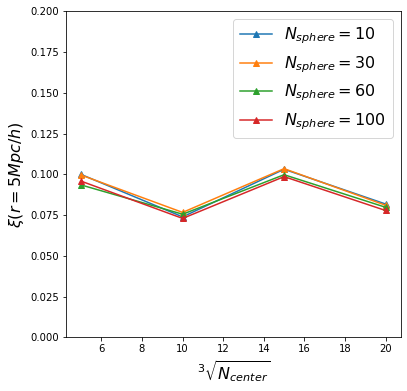

In [9]:
stabcheck=np.array(stabcheck)
plt.figure().set_size_inches([6,6])
plt.plot(stabcheck[0::4,0],stabcheck[0::4,2],marker='^',label='$N_{sphere} = 10$')
plt.plot(stabcheck[1::4,0],stabcheck[1::4,2],marker='^',label='$N_{sphere} = 30$')
plt.plot(stabcheck[2::4,0],stabcheck[2::4,2],marker='^',label='$N_{sphere} = 60$')
plt.plot(stabcheck[3::4,0],stabcheck[3::4,2],marker='^',label='$N_{sphere} = 100$')

plt.ylim(0,0.2)
plt.xlabel('$^3\\sqrt{N_{center}}$',fontsize=16)
plt.ylabel('$ \\xi (r= %.0f Mpc/h) $'%sampleradius,fontsize=16)
plt.legend(fontsize=16)